In [15]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Libraries are already installed. Skipping setup.
Dataset already unzipped.


Starting training on cuda...
E 10/100 | V_Loss: 0.1516 | V_SSIM: 0.8476
E 20/100 | V_Loss: 0.0595 | V_SSIM: 0.9020
E 30/100 | V_Loss: 0.0336 | V_SSIM: 0.9079
E 40/100 | V_Loss: 0.0181 | V_SSIM: 0.9451
E 50/100 | V_Loss: 0.0086 | V_SSIM: 0.9556
E 60/100 | V_Loss: 0.0048 | V_SSIM: 0.9784
E 70/100 | V_Loss: 0.0036 | V_SSIM: 0.9853
E 80/100 | V_Loss: 0.0028 | V_SSIM: 0.9854
E 90/100 | V_Loss: 0.0024 | V_SSIM: 0.9925
E 100/100 | V_Loss: 0.0013 | V_SSIM: 0.9958


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,██▇▆▅▅▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_psnr,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▅▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
val_ssim,▁▂▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,99
train_loss,0.00689
val_loss,0.00128
val_psnr,45.40478
val_ssim,0.99579



Training complete. Model saved to conditioned_unet.pth

--- Running Inference ---


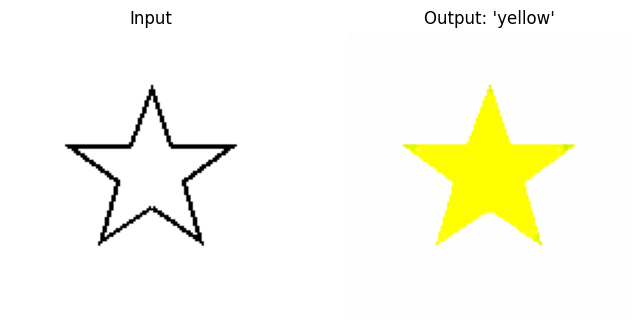

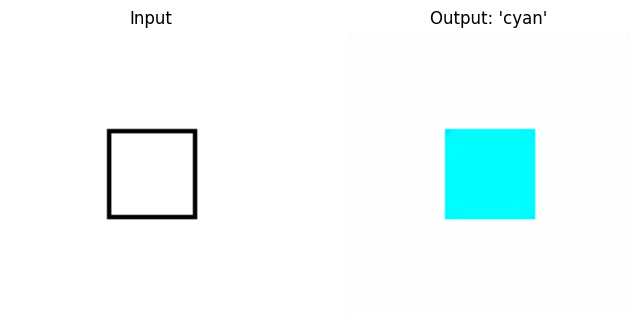

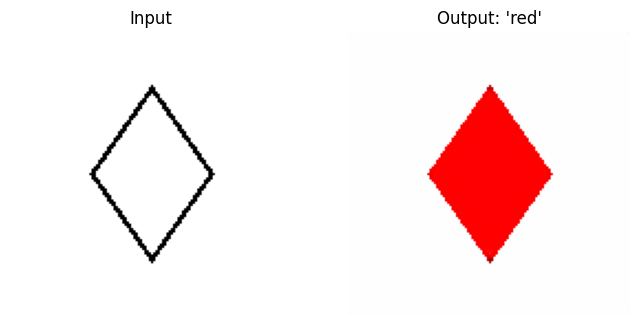

In [16]:
# ==============================================================================
# FINAL PUBLIC SUBMISSION SCRIPT
# ==============================================================================
# Instructions:
# 1. Upload your 'dataset.zip' file to Colab.
# 2. Run this entire cell. It will install libraries and restart the runtime.
# 3. After the restart, run this SAME cell again. It will train the model
#    and create a NEW wandb project under your personal account.

import os
import sys

# --- PART 1: SETUP AND INSTALLATION ---
try:
    import torch
    import wandb
    assert torch.__version__.startswith("2.3")
    print("Libraries are already installed. Skipping setup.")
    SETUP_DONE = True
except (ImportError, AssertionError):
    print("Performing first-time setup. Installing required libraries...")
    !pip install -q torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
    !pip install -q wandb torchmetrics sympy==1.11
    print("\nInstallation complete. The Colab runtime will now restart.")
    print("Please run this cell again after the restart.")
    os.kill(os.getpid(), 9)
    SETUP_DONE = False

if SETUP_DONE:
    if not os.path.exists("dataset"):
        print("Unzipping dataset...")
        !unzip -q dataset.zip
    else:
        print("Dataset already unzipped.")

    import json
    import random
    from PIL import Image
    import matplotlib.pyplot as plt

    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torchvision.transforms as T
    from torchvision.transforms import functional as F
    from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
    import wandb

    config = {
        "project_name": "public-polygon-colorizer-submission",
        "image_size": 128,
        "batch_size": 32,
        "embedding_dim": 32,
        "learning_rate": 1e-3,
        "epochs": 100,
        "unet_channels": (64, 128, 256, 512),
        "dataset_path": "dataset",
        "device": "cuda" if torch.cuda.is_available() else "cpu",
    }

    # --- Dataset and Dataloader ---
    class PolygonDataset(Dataset):
        def __init__(self, root_dir, data_json_path, color_vocab=None, image_size=128, augment=False):
            self.root_dir, self.image_size, self.augment = root_dir, image_size, augment
            with open(data_json_path, 'r') as f: self.data_map = json.load(f)
            self.color_vocab, self.idx_to_color = (self._create_color_vocab() if color_vocab is None
                                                   else (color_vocab, {v: k for k, v in color_vocab.items()}))
            self.base_transforms = T.Compose([T.Resize((self.image_size, self.image_size)), T.ToTensor()])
        def _create_color_vocab(self):
            colors = sorted(list(set(item['colour'] for item in self.data_map)))
            vocab = {color: i for i, color in enumerate(colors)}
            return vocab, {i: color for color, i in vocab.items()}
        def __len__(self): return len(self.data_map)
        def __getitem__(self, idx):
            item = self.data_map[idx]
            input_img = Image.open(os.path.join(self.root_dir, 'inputs', item['input_polygon'])).convert('L')
            output_img = Image.open(os.path.join(self.root_dir, 'outputs', item['output_image'])).convert('RGB')
            if self.augment:
                if random.random() > 0.5: input_img, output_img = F.hflip(input_img), F.hflip(output_img)
                if random.random() > 0.5:
                    angle = random.uniform(-30, 30)
                    input_img, output_img = F.rotate(input_img, angle), F.rotate(output_img, angle)
            return (self.base_transforms(input_img),
                    torch.tensor(self.color_vocab[item['colour']], dtype=torch.long),
                    self.base_transforms(output_img))

    # --- Model Architecture (identical to the one used for inference) ---
    class FiLMLayer(nn.Module):
        def __init__(self, c, ed): super().__init__(); self.l = nn.Linear(ed, c * 2)
        def forward(self, x, e):
            gb = self.l(e).unsqueeze(-1).unsqueeze(-1); g, b = torch.chunk(gb, 2, dim=1); return g * x + b
    class UNetBlock(nn.Module):
        def __init__(self, ic, oc, d=0.2):
            super().__init__(); self.c = nn.Sequential(
                nn.Conv2d(ic, oc, 3, 1, 1, bias=False), nn.BatchNorm2d(oc), nn.ReLU(True), nn.Dropout2d(d),
                nn.Conv2d(oc, oc, 3, 1, 1, bias=False), nn.BatchNorm2d(oc), nn.ReLU(True))
        def forward(self, x): return self.c(x)
    class ConditionedUNet(nn.Module):
        def __init__(self, ic=1, oc=3, ch=(64, 128, 256, 512), nc=10, ed=32):
            super().__init__(); self.ce = nn.Embedding(nc, ed); self.enc = nn.ModuleList()
            for i in range(len(ch)): self.enc.append(UNetBlock(ic if i == 0 else ch[i-1], ch[i]))
            self.p = nn.MaxPool2d(2); self.b = UNetBlock(ch[-1], ch[-1] * 2)
            self.dec, self.fl = nn.ModuleList(), nn.ModuleList(); rc = ch[::-1]
            for i in range(len(rc)):
                self.dec.append(nn.ConvTranspose2d(rc[i]*2, rc[i], 2, 2)); self.dec.append(UNetBlock(rc[i]*2, rc[i]))
                self.fl.append(FiLMLayer(rc[i], ed))
            self.f = nn.Conv2d(ch[0], oc, 1)
        def forward(self, x, ci):
            e = self.ce(ci); sk = [];
            for en in self.enc: x = en(x); sk.append(x); x = self.p(x)
            x = self.b(x); sk = sk[::-1]
            for i in range(0, len(self.dec), 2):
                x = self.dec[i](x); s = sk[i//2]
                if x.shape != s.shape: x = F.resize(x, size=s.shape[2:])
                x = self.dec[i+1](torch.cat((s, x), dim=1)); x = self.fl[i//2](x, e)
            return torch.sigmoid(self.f(x))

    # --- Training Loop ---
    def run_training(config):
        wandb.init(project=config["project_name"], config=config)
        train_json = os.path.join(config["dataset_path"], 'training', 'data.json')
        val_json = os.path.join(config["dataset_path"], 'validation', 'data.json')
        ds = PolygonDataset(os.path.join(config["dataset_path"], 'training'), train_json)
        cv = ds.color_vocab
        train_ds = PolygonDataset(os.path.join(config["dataset_path"], 'training'), train_json, cv, config["image_size"], True)
        val_ds = PolygonDataset(os.path.join(config["dataset_path"], 'validation'), val_json, cv, config["image_size"], False)
        train_loader = DataLoader(train_ds, config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_ds, config["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
        model = ConditionedUNet(nc=len(cv), ed=config["embedding_dim"], ch=config["unet_channels"]).to(config["device"])
        loss_fn = nn.L1Loss(); optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"])
        ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(config["device"])
        psnr = PeakSignalNoiseRatio(data_range=1.0).to(config["device"])
        print(f"Starting training on {config['device']}...")
        for epoch in range(config["epochs"]):
            model.train(); t_loss = 0
            for ix, cx, tx in train_loader:
                ix, cx, tx = ix.to(config["device"]), cx.to(config["device"]), tx.to(config["device"])
                gx = model(ix, cx); loss = loss_fn(gx, tx)
                optimizer.zero_grad(); loss.backward(); optimizer.step(); t_loss += loss.item()
            model.eval(); v_loss, imgs = 0, []
            with torch.no_grad():
                for i, (ix, cx, tx) in enumerate(val_loader):
                    ix, cx, tx = ix.to(config["device"]), cx.to(config["device"]), tx.to(config["device"])
                    gx = model(ix, cx); v_loss += loss_fn(gx, tx).item(); ssim.update(gx, tx); psnr.update(gx, tx)
                    if i == 0:
                        itc = {v: k for k, v in cv.items()}; cns = [itc[c.item()] for c in cx]
                        for j in range(min(gx.size(0), 4)):
                            imgs.extend([wandb.Image(gx[j].cpu(), caption=f"P:{cns[j]}"), wandb.Image(tx[j].cpu(), caption=f"G:{cns[j]}")])
            v_s, v_p = ssim.compute(), psnr.compute(); ssim.reset(); psnr.reset()
            wandb.log({"epoch": epoch, "train_loss": t_loss/len(train_loader), "val_loss": v_loss/len(val_loader),
                       "val_ssim": v_s.item(), "val_psnr": v_p.item(), "samples": imgs})
            if (epoch + 1) % 10 == 0: print(f"E {epoch+1}/{config['epochs']} | V_Loss: {v_loss/len(val_loader):.4f} | V_SSIM: {v_s:.4f}")
        model_path = "conditioned_unet.pth"
        torch.save(model.state_dict(), model_path)
        wandb.save(model_path); wandb.finish()
        print(f"\nTraining complete. Model saved to {model_path}")
        return model_path, cv

    # --- PART 3: INFERENCE SCRIPT ---
    def run_inference(model_path, color_vocab, config):
        print("\n--- Running Inference ---")
        model = ConditionedUNet(nc=len(color_vocab), ed=config["embedding_dim"], ch=config["unet_channels"]).to(config["device"])
        model.load_state_dict(torch.load(model_path, map_location=torch.device(config["device"])))
        model.eval()
        def colorize(poly_path, color_name):
            input_img = Image.open(poly_path).convert('L')
            transform = T.Compose([T.Resize((config["image_size"], config["image_size"])), T.ToTensor()])
            input_tensor = transform(input_img).unsqueeze(0).to(config["device"])
            if color_name not in color_vocab:
                print(f"Color '{color_name}' not found. Available: {list(color_vocab.keys())}")
                return
            color_idx = torch.tensor([color_vocab[color_name]], dtype=torch.long).to(config["device"])
            with torch.no_grad(): output_tensor = model(input_tensor, color_idx)
            output_img = T.ToPILImage()(output_tensor.squeeze(0).cpu())
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(input_img, cmap='gray'); ax[0].set_title("Input"); ax[0].axis('off')
            ax[1].imshow(output_img); ax[1].set_title(f"Output: '{color_name}'"); ax[1].axis('off')
            plt.show()
        # Run some examples
        colorize(f"{config['dataset_path']}/validation/inputs/star.png", "yellow")
        colorize(f"{config['dataset_path']}/validation/inputs/square.png", "cyan")
        colorize(f"{config['dataset_path']}/training/inputs/diamond.png", "red")

    # --- Main Execution Block ---
    if __name__ == '__main__' and SETUP_DONE:
        trained_model_path, color_vocabulary = run_training(config)
        run_inference(trained_model_path, color_vocabulary, config)


In [ ]:
137c32451ec4d0c381c621429d07404876590620